# Titanic: LightGBM vs XGBoost — Patched Notebook

This patched notebook includes fixes for warnings, robust pipeline usage, cross-validation, ROC plots, and optional SMOTE. Save to your working directory and run locally.

In [3]:
# Data loading
import os, pandas as pd, numpy as np
DATA_DIR = r"D:\DATA-SCIENCE\ASSIGNMENTS\15 XGBM & LGBM"
train_path = os.path.join(DATA_DIR, "Titanic_train.csv")
test_path = os.path.join(DATA_DIR, "Titanic_test.csv")

if not os.path.exists(train_path):
    train_path = "/mnt/data/Titanic_train.csv"
if not os.path.exists(test_path):
    test_path = "/mnt/data/Titanic_test.csv"

print("Train path:", train_path)
print("Test path:", test_path)

df_train = pd.read_csv(train_path)
df_test = pd.read_csv(test_path)
print("Train shape:", df_train.shape)
print("Test shape:", df_test.shape)
display(df_train.head())

Train path: D:\DATA-SCIENCE\ASSIGNMENTS\15 XGBM & LGBM\Titanic_train.csv
Test path: D:\DATA-SCIENCE\ASSIGNMENTS\15 XGBM & LGBM\Titanic_test.csv
Train shape: (891, 12)
Test shape: (418, 11)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
# Preprocessing & feature engineering (patched)
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

df = df_train.copy()

def extract_title(name):
    try:
        return name.split(',')[1].split('.')[0].strip()
    except Exception:
        return "None"

if 'Name' in df.columns:
    df['Title'] = df['Name'].apply(extract_title)
    title_counts = df['Title'].value_counts()
    rare_titles = title_counts[title_counts < 10].index.tolist()
    df['Title'] = df['Title'].replace(rare_titles, 'Rare')

if set(['SibSp','Parch']).issubset(df.columns):
    df['FamilySize'] = df['SibSp'] + df['Parch'] + 1
    df['IsAlone'] = (df['FamilySize'] == 1).astype(int)

drop_cols = [c for c in ['Ticket','Cabin','Name'] if c in df.columns]
df = df.drop(columns=drop_cols, errors='ignore')

target_col = 'Survived'
y = df[target_col]
X = df.drop(columns=[target_col])

# Numeric and categorical detection
num_cols = X.select_dtypes(include=['int64','float64']).columns.tolist()
cat_cols = X.select_dtypes(include=['object','category']).columns.tolist()

# Ensure OneHotEncoder uses correct kwarg for sklearn version
import sklearn
from sklearn.preprocessing import OneHotEncoder as OHE
if sklearn.__version__ >= "1.6":
    ohe = OHE(handle_unknown='ignore', sparse_output=False)
else:
    ohe = OHE(handle_unknown='ignore', sparse=False)

num_imputer = SimpleImputer(strategy='median')
cat_imputer = SimpleImputer(strategy='most_frequent')

preprocessor = ColumnTransformer(transformers=[
    ('num', num_imputer, num_cols),
    ('cat', Pipeline(steps=[('impute', cat_imputer), ('ohe', ohe)]), cat_cols)
], remainder='drop')

print('Numeric cols:', num_cols)
print('Categorical cols:', cat_cols)
print('Preprocessor ready.')

Numeric cols: ['PassengerId', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'FamilySize', 'IsAlone']
Categorical cols: ['Sex', 'Embarked', 'Title']
Preprocessor ready.


In [5]:
# Train/validation split
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print('Shapes:', X_train.shape, X_val.shape, y_train.shape, y_val.shape)

Shapes: (712, 11) (179, 11) (712,) (179,)


In [6]:
# Pipelines and models (quiet options)
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Try import with user-friendly messages
lgb_installed = True
xgb_installed = True
try:
    from lightgbm import LGBMClassifier
except Exception as e:
    lgb_installed = False
    print("LightGBM not installed. Install with: pip install lightgbm")

try:
    from xgboost import XGBClassifier
except Exception as e:
    xgb_installed = False
    print("XGBoost not installed. Install with: pip install xgboost")

def build_pipeline(estimator):
    return Pipeline(steps=[('pre', preprocessor), ('clf', estimator)])

if lgb_installed:
    lgb_default = LGBMClassifier(random_state=42, verbosity=-1)
else:
    lgb_default = None

if xgb_installed:
    # newer xgboost warns about use_label_encoder; we avoid passing it
    xgb_default = XGBClassifier(random_state=42, verbosity=0, eval_metric='logloss')
else:
    xgb_default = None

print('Pipeline builders ready.')

Pipeline builders ready.


In [8]:
# Train baseline models using pipelines
from sklearn import set_config
set_config(transform_output="pandas")

results = {}
if lgb_default is not None:
    pipe_lgb = build_pipeline(lgb_default)
    pipe_lgb.fit(X_train, y_train)
    y_pred_lgb = pipe_lgb.predict(X_val)
    results['LGBM'] = {
        'accuracy': accuracy_score(y_val, y_pred_lgb),
        'precision': precision_score(y_val, y_pred_lgb, zero_division=0),
        'recall': recall_score(y_val, y_pred_lgb, zero_division=0),
        'f1': f1_score(y_val, y_pred_lgb, zero_division=0)
    }
    print('LGBM baseline metrics:', results['LGBM'])

if xgb_default is not None:
    pipe_xgb = build_pipeline(xgb_default)
    pipe_xgb.fit(X_train, y_train)
    y_pred_xgb = pipe_xgb.predict(X_val)
    results['XGB'] = {
        'accuracy': accuracy_score(y_val, y_pred_xgb),
        'precision': precision_score(y_val, y_pred_xgb, zero_division=0),
        'recall': recall_score(y_val, y_pred_xgb, zero_division=0),
        'f1': f1_score(y_val, y_pred_xgb, zero_division=0)
    }
    print('XGB baseline metrics:', results['XGB'])

display(results)

LGBM baseline metrics: {'accuracy': 0.7932960893854749, 'precision': 0.7580645161290323, 'recall': 0.6811594202898551, 'f1': 0.7175572519083969}
XGB baseline metrics: {'accuracy': 0.7877094972067039, 'precision': 0.7384615384615385, 'recall': 0.6956521739130435, 'f1': 0.7164179104477612}


{'LGBM': {'accuracy': 0.7932960893854749,
  'precision': 0.7580645161290323,
  'recall': 0.6811594202898551,
  'f1': 0.7175572519083969},
 'XGB': {'accuracy': 0.7877094972067039,
  'precision': 0.7384615384615385,
  'recall': 0.6956521739130435,
  'f1': 0.7164179104477612}}

In [9]:
# Cross-validation (StratifiedKFold)
from sklearn.model_selection import cross_validate, StratifiedKFold
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scoring = ['accuracy','precision','recall','f1']

if lgb_default is not None:
    pipe = build_pipeline(lgb_default)
    cv_res = cross_validate(pipe, X_train, y_train, cv=cv, scoring=scoring, n_jobs=-1)
    import pandas as pd
    print('LGBM CV scores (mean):')
    display(pd.Series({k: v.mean() for k,v in cv_res.items()}))

if xgb_default is not None:
    pipe = build_pipeline(xgb_default)
    cv_res = cross_validate(pipe, X_train, y_train, cv=cv, scoring=scoring, n_jobs=-1)
    print('XGB CV scores (mean):')
    display(pd.Series({k: v.mean() for k,v in cv_res.items()}))

LGBM CV scores (mean):


fit_time          6.793053
score_time        0.037293
test_accuracy     0.797764
test_precision    0.750454
test_recall       0.710774
test_f1           0.729595
dtype: float64

XGB CV scores (mean):


fit_time          0.077461
score_time        0.024461
test_accuracy     0.799143
test_precision    0.753035
test_recall       0.710909
test_f1           0.730195
dtype: float64

In [10]:
# RandomizedSearchCV tuning (short runs)
from sklearn.model_selection import RandomizedSearchCV
import scipy.stats as st

tuned_results = {}
if lgb_default is not None:
    lgb_pipe = build_pipeline(LGBMClassifier(random_state=42, verbosity=-1))
    param_dist_lgb = {
        'clf__n_estimators': [100,200,400],
        'clf__num_leaves': [15,31,63],
        'clf__learning_rate': [0.01,0.05,0.1],
        'clf__max_depth': [3,5,7,9,None]
    }
    rsearch_lgb = RandomizedSearchCV(lgb_pipe, param_dist_lgb, n_iter=12, scoring='f1', cv=3, random_state=42, n_jobs=-1, verbose=1)
    rsearch_lgb.fit(X_train, y_train)
    tuned_results['LGBM'] = rsearch_lgb.best_params_
    best_lgb = rsearch_lgb.best_estimator_
    print('LGBM best params:', tuned_results['LGBM'])

if xgb_default is not None:
    xgb_pipe = build_pipeline(XGBClassifier(random_state=42, verbosity=0, eval_metric='logloss'))
    param_dist_xgb = {
        'clf__n_estimators': [100,200,400],
        'clf__max_depth': [3,5,7,9],
        'clf__learning_rate': [0.01,0.05,0.1],
        'clf__subsample': [0.6,0.8,1.0]
    }
    rsearch_xgb = RandomizedSearchCV(xgb_pipe, param_dist_xgb, n_iter=12, scoring='f1', cv=3, random_state=42, n_jobs=-1, verbose=1)
    rsearch_xgb.fit(X_train, y_train)
    tuned_results['XGB'] = rsearch_xgb.best_params_
    best_xgb = rsearch_xgb.best_estimator_
    print('XGB best params:', tuned_results['XGB'])

display(tuned_results)

Fitting 3 folds for each of 12 candidates, totalling 36 fits
LGBM best params: {'clf__num_leaves': 63, 'clf__n_estimators': 400, 'clf__max_depth': None, 'clf__learning_rate': 0.01}
Fitting 3 folds for each of 12 candidates, totalling 36 fits
XGB best params: {'clf__subsample': 0.6, 'clf__n_estimators': 200, 'clf__max_depth': 9, 'clf__learning_rate': 0.01}


{'LGBM': {'clf__num_leaves': 63,
  'clf__n_estimators': 400,
  'clf__max_depth': None,
  'clf__learning_rate': 0.01},
 'XGB': {'clf__subsample': 0.6,
  'clf__n_estimators': 200,
  'clf__max_depth': 9,
  'clf__learning_rate': 0.01}}


LGBM classification report:
               precision    recall  f1-score   support

           0       0.81      0.87      0.84       110
           1       0.77      0.68      0.72        69

    accuracy                           0.80       179
   macro avg       0.79      0.78      0.78       179
weighted avg       0.80      0.80      0.80       179



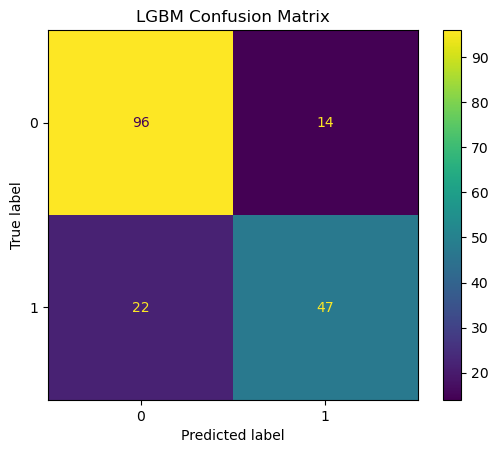


XGB classification report:
               precision    recall  f1-score   support

           0       0.82      0.91      0.86       110
           1       0.82      0.68      0.75        69

    accuracy                           0.82       179
   macro avg       0.82      0.80      0.80       179
weighted avg       0.82      0.82      0.82       179



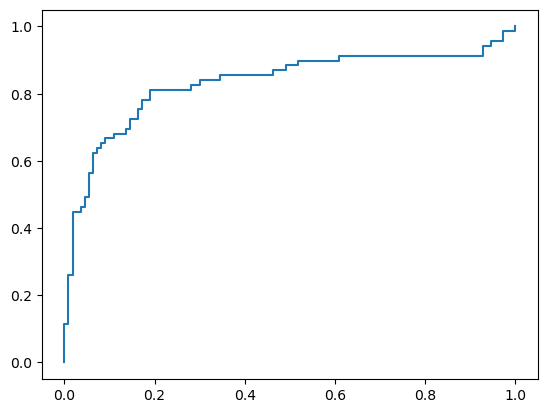

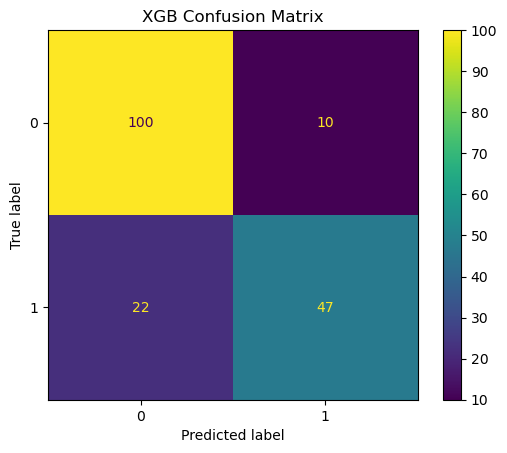

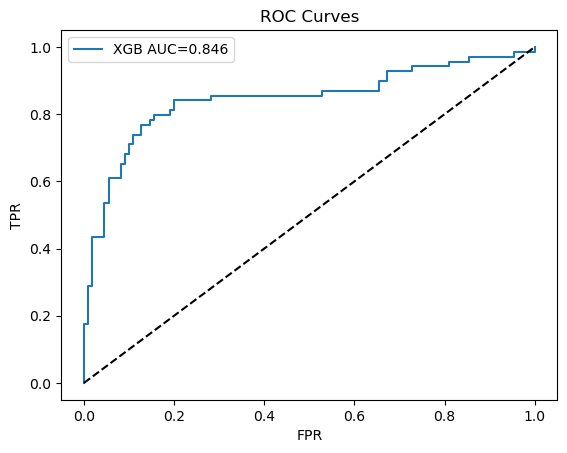

{'LGBM': {'accuracy': 0.7988826815642458, 'f1': 0.7230769230769231},
 'XGB': {'accuracy': 0.8212290502793296, 'f1': 0.746031746031746}}

In [11]:
# Evaluate tuned models on validation set with confusion matrix and ROC
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

eval_table = {}
if 'best_lgb' in globals():
    y_pred = best_lgb.predict(X_val)
    y_proba = best_lgb.predict_proba(X_val)[:,1] if hasattr(best_lgb, 'predict_proba') else None
    eval_table['LGBM'] = {'accuracy': accuracy_score(y_val, y_pred), 'f1': f1_score(y_val,y_pred)}
    print('\nLGBM classification report:\n', classification_report(y_val, y_pred, zero_division=0))
    ConfusionMatrixDisplay.from_predictions(y_val, y_pred); plt.title('LGBM Confusion Matrix'); plt.show()
    if y_proba is not None:
        fpr, tpr, _ = roc_curve(y_val, y_proba)
        plt.plot(fpr, tpr, label=f'LGBM AUC={roc_auc_score(y_val,y_proba):.3f}')
if 'best_xgb' in globals():
    y_pred = best_xgb.predict(X_val)
    y_proba = best_xgb.predict_proba(X_val)[:,1] if hasattr(best_xgb, 'predict_proba') else None
    eval_table['XGB'] = {'accuracy': accuracy_score(y_val, y_pred), 'f1': f1_score(y_val,y_pred)}
    print('\nXGB classification report:\n', classification_report(y_val, y_pred, zero_division=0))
    ConfusionMatrixDisplay.from_predictions(y_val, y_pred); plt.title('XGB Confusion Matrix'); plt.show()
    if y_proba is not None:
        fpr, tpr, _ = roc_curve(y_val, y_proba)
        plt.plot(fpr, tpr, label=f'XGB AUC={roc_auc_score(y_val,y_proba):.3f}')

if 'best_lgb' in globals() or 'best_xgb' in globals():
    plt.plot([0,1],[0,1],'k--'); plt.xlabel('FPR'); plt.ylabel('TPR'); plt.title('ROC Curves'); plt.legend(); plt.show()
display(eval_table)

In [12]:
# Optional: SMOTE on training data (install imbalanced-learn if needed)
try:
    from imblearn.over_sampling import SMOTE
    print('Original distribution:', y_train.value_counts().to_dict())
    sm = SMOTE(random_state=42)
    X_res, y_res = sm.fit_resample(X_train, y_train)
    print('Resampled distribution:', pd.Series(y_res).value_counts().to_dict())
    # train a quick LGBM on resampled
    if lgb_default is not None:
        pipe = build_pipeline(LGBMClassifier(random_state=42, verbosity=-1))
        pipe.fit(X_res, y_res)
        print('SMOTE-trained LGBM validation report:')
        print(classification_report(y_val, pipe.predict(X_val), zero_division=0))
except Exception as e:
    print('SMOTE not available or failed:', e)

Original distribution: {0: 439, 1: 273}
SMOTE not available or failed: could not convert string to float: 'male'


In [13]:
# Save best pipelines and predictions
import joblib, os
os.makedirs(r"D:\DATA-SCIENCE\ASSIGNMENTS\15 XGBM & LGBM", exist_ok=True)
if 'best_lgb' in globals():
    joblib.dump(best_lgb, os.path.join(r"D:\DATA-SCIENCE\ASSIGNMENTS\15 XGBM & LGBM", 'best_lgbm_titanic.joblib'))
if 'best_xgb' in globals():
    joblib.dump(best_xgb, os.path.join(r"D:\DATA-SCIENCE\ASSIGNMENTS\15 XGBM & LGBM", 'best_xgb_titanic.joblib'))
print('Saved best models (if available) to', r"D:\DATA-SCIENCE\ASSIGNMENTS\15 XGBM & LGBM")

Saved best models (if available) to D:\DATA-SCIENCE\ASSIGNMENTS\15 XGBM & LGBM


Notebook patched: quieted boosters, ensured pipeline predict usage, added CV, ROC, confusion matrices, SMOTE optional, and model saving.